In [1]:
rm(list = ls())
library(LalRUtils)
libreq(data.table, tidyverse, anytime, patchwork, plotly, lubridate, zoo)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 15, repr.plot.height=12)

     wants        loaded
[1,] "data.table" TRUE  
[2,] "tidyverse"  TRUE  
[3,] "anytime"    TRUE  
[4,] "patchwork"  TRUE  
[5,] "plotly"     TRUE  
[6,] "lubridate"  TRUE  
[7,] "zoo"        TRUE  


# NYT county level time series 
https://github.com/nytimes/covid-19-data

In [2]:
#%% check timestamp at https://github.com/nytimes/covid-19-data
df = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df[, d := anydate(date)]

In [3]:
setorder(df, state, county, date)
df[order(-date, -cases)][1:20]

date       county        state         fips  cases  deaths d         
1  2020-04-24 New York City New York         NA 150484 11157  2020-04-24
2  2020-04-24 Nassau        New York      36059  32765  1867  2020-04-24
3  2020-04-24 Suffolk       New York      36103  30606  1035  2020-04-24
4  2020-04-24 Cook          Illinois      17031  27616  1220  2020-04-24
5  2020-04-24 Westchester   New York      36119  26632   989  2020-04-24
6  2020-04-24 Los Angeles   California     6037  18545   850  2020-04-24
7  2020-04-24 Wayne         Michigan      26163  15407  1443  2020-04-24
8  2020-04-24 Bergen        New Jersey    34003  14363   934  2020-04-24
9  2020-04-24 Hudson        New Jersey    34017  13011   640  2020-04-24
10 2020-04-24 Essex         New Jersey    34013  12110   975  2020-04-24
11 2020-04-24 Philadelphia  Pennsylvania  42101  11877   449  2020-04-24
12 2020-04-24 Middlesex     Massachusetts 25017  11681   585  2020-04-24
13 2020-04-24 Union         New Jersey    34039  11208   542  2020-04-24
14 2020-04-24 Miami-Dade    Florida       12086  10925   287  2020-04-24
15 2020-04-24 Suffolk       Massachusetts 25025  10724   372  2020-04-24
16 2020-04-24 Passaic       New Jersey    34031  10291   383  2020-04-24
17 2020-04-24 Fairfield     Connecticut    9001  10227   662  2020-04-24
18 2020-04-24 Rockland      New York      36087  10091   334  2020-04-24
19 2020-04-24 Middlesex     New Jersey    34023   9789   413  2020-04-24
20 2020-04-24 Orange        New York      36071   7170   194  2020-04-24

In [4]:
df[,  `:=`(
  cfr = deaths/cases,
  new_cases  = cases - shift(cases),
  new_deaths = deaths - shift(deaths)
), by = .(state, county)]
# clean up
df[ ,`:=`(new_deaths = ifelse(new_deaths < 0, 0, new_deaths),
          new_cases  = ifelse(new_cases < 0, 0, new_cases)
              )]

df = df[d >= "2020-03-01"]
rawvars = c("cases", "deaths", "new_cases", "new_deaths")

### Rolling Mean Function

In [5]:
rollmeaneR = function(df, 
                      smoothvars = rawvars,
                      grouping = c("state", "county"),
                      sm_k = 5){
    f = copy(df)
    setorderv(f, cols = c(grouping, 'd'))
    f[, paste0("rm", "_", smoothvars) := lapply(.SD, rollmean, k = sm_k, fill = NA, na.pad = T), 
       by = grouping, .SDcols = smoothvars]
    return(f)
}

# Nationwide 

In [6]:
npan = df[, lapply(.SD, sum, na.rm = T), by = .(d), .SDcols = rawvars]
npan[, gr := 1]
npan[, cfr := deaths/cases]
npan = rollmeaneR(npan, grouping = "gr")
npan[, day := weekdays(d)]
npan[, weekend := ifelse(day %in% c("Saturday", "Sunday"), 1, 0)]
npan[order(-d)][1:5]

d          cases  deaths new_cases new_deaths gr cfr     rm_cases rm_deaths
1 2020-04-24 904564 46503  37961     2040       1  0.05141     NA      NA    
2 2020-04-23 867276 44508  34294     2113       1  0.05132     NA      NA    
3 2020-04-22 833492 42498  27844     2194       1  0.05099 838310   42324    
4 2020-04-21 805773 40316  25927     2627       1  0.05003 808061   40245    
5 2020-04-20 780443 37795  27254     1694       1  0.04843 780225   38289    
  rm_new_cases rm_new_deaths day       weekend
1    NA          NA          Friday    0      
2    NA          NA          Thursday  0      
3 30656        2134          Wednesday 0      
4 28220        2252          Tuesday   0      
5 27058        2201          Monday    0

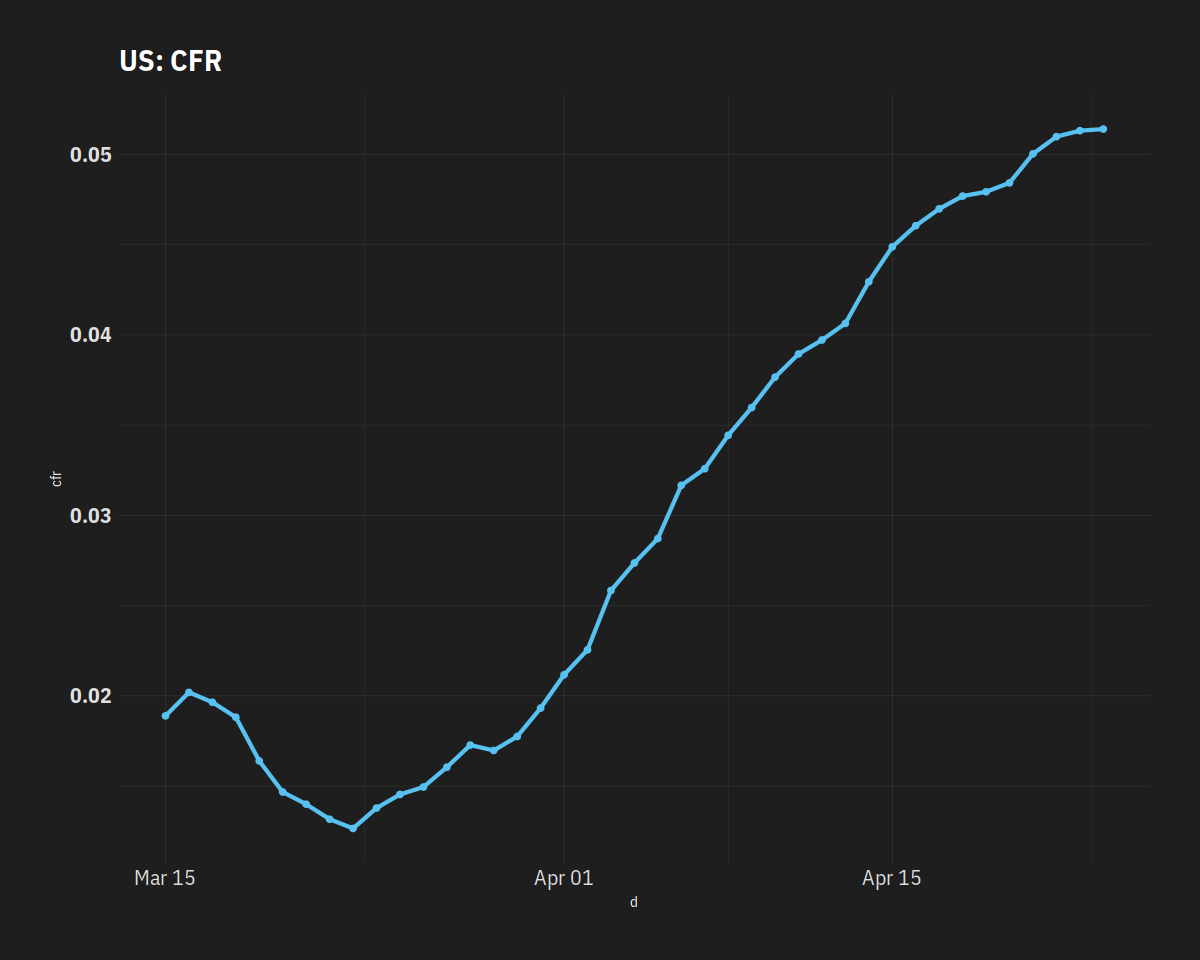

In [7]:
options(repr.plot.width = 10, repr.plot.height=8)
ggplot(npan[d>= "2020-03-15"], aes(x = d, y = cfr)) +
  geom_line(size = 1.2) + geom_point()+ 
  ggtitle("US: CFR")

Warning message:
“Removed 4 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 4 row(s) containing missing values (geom_path).”


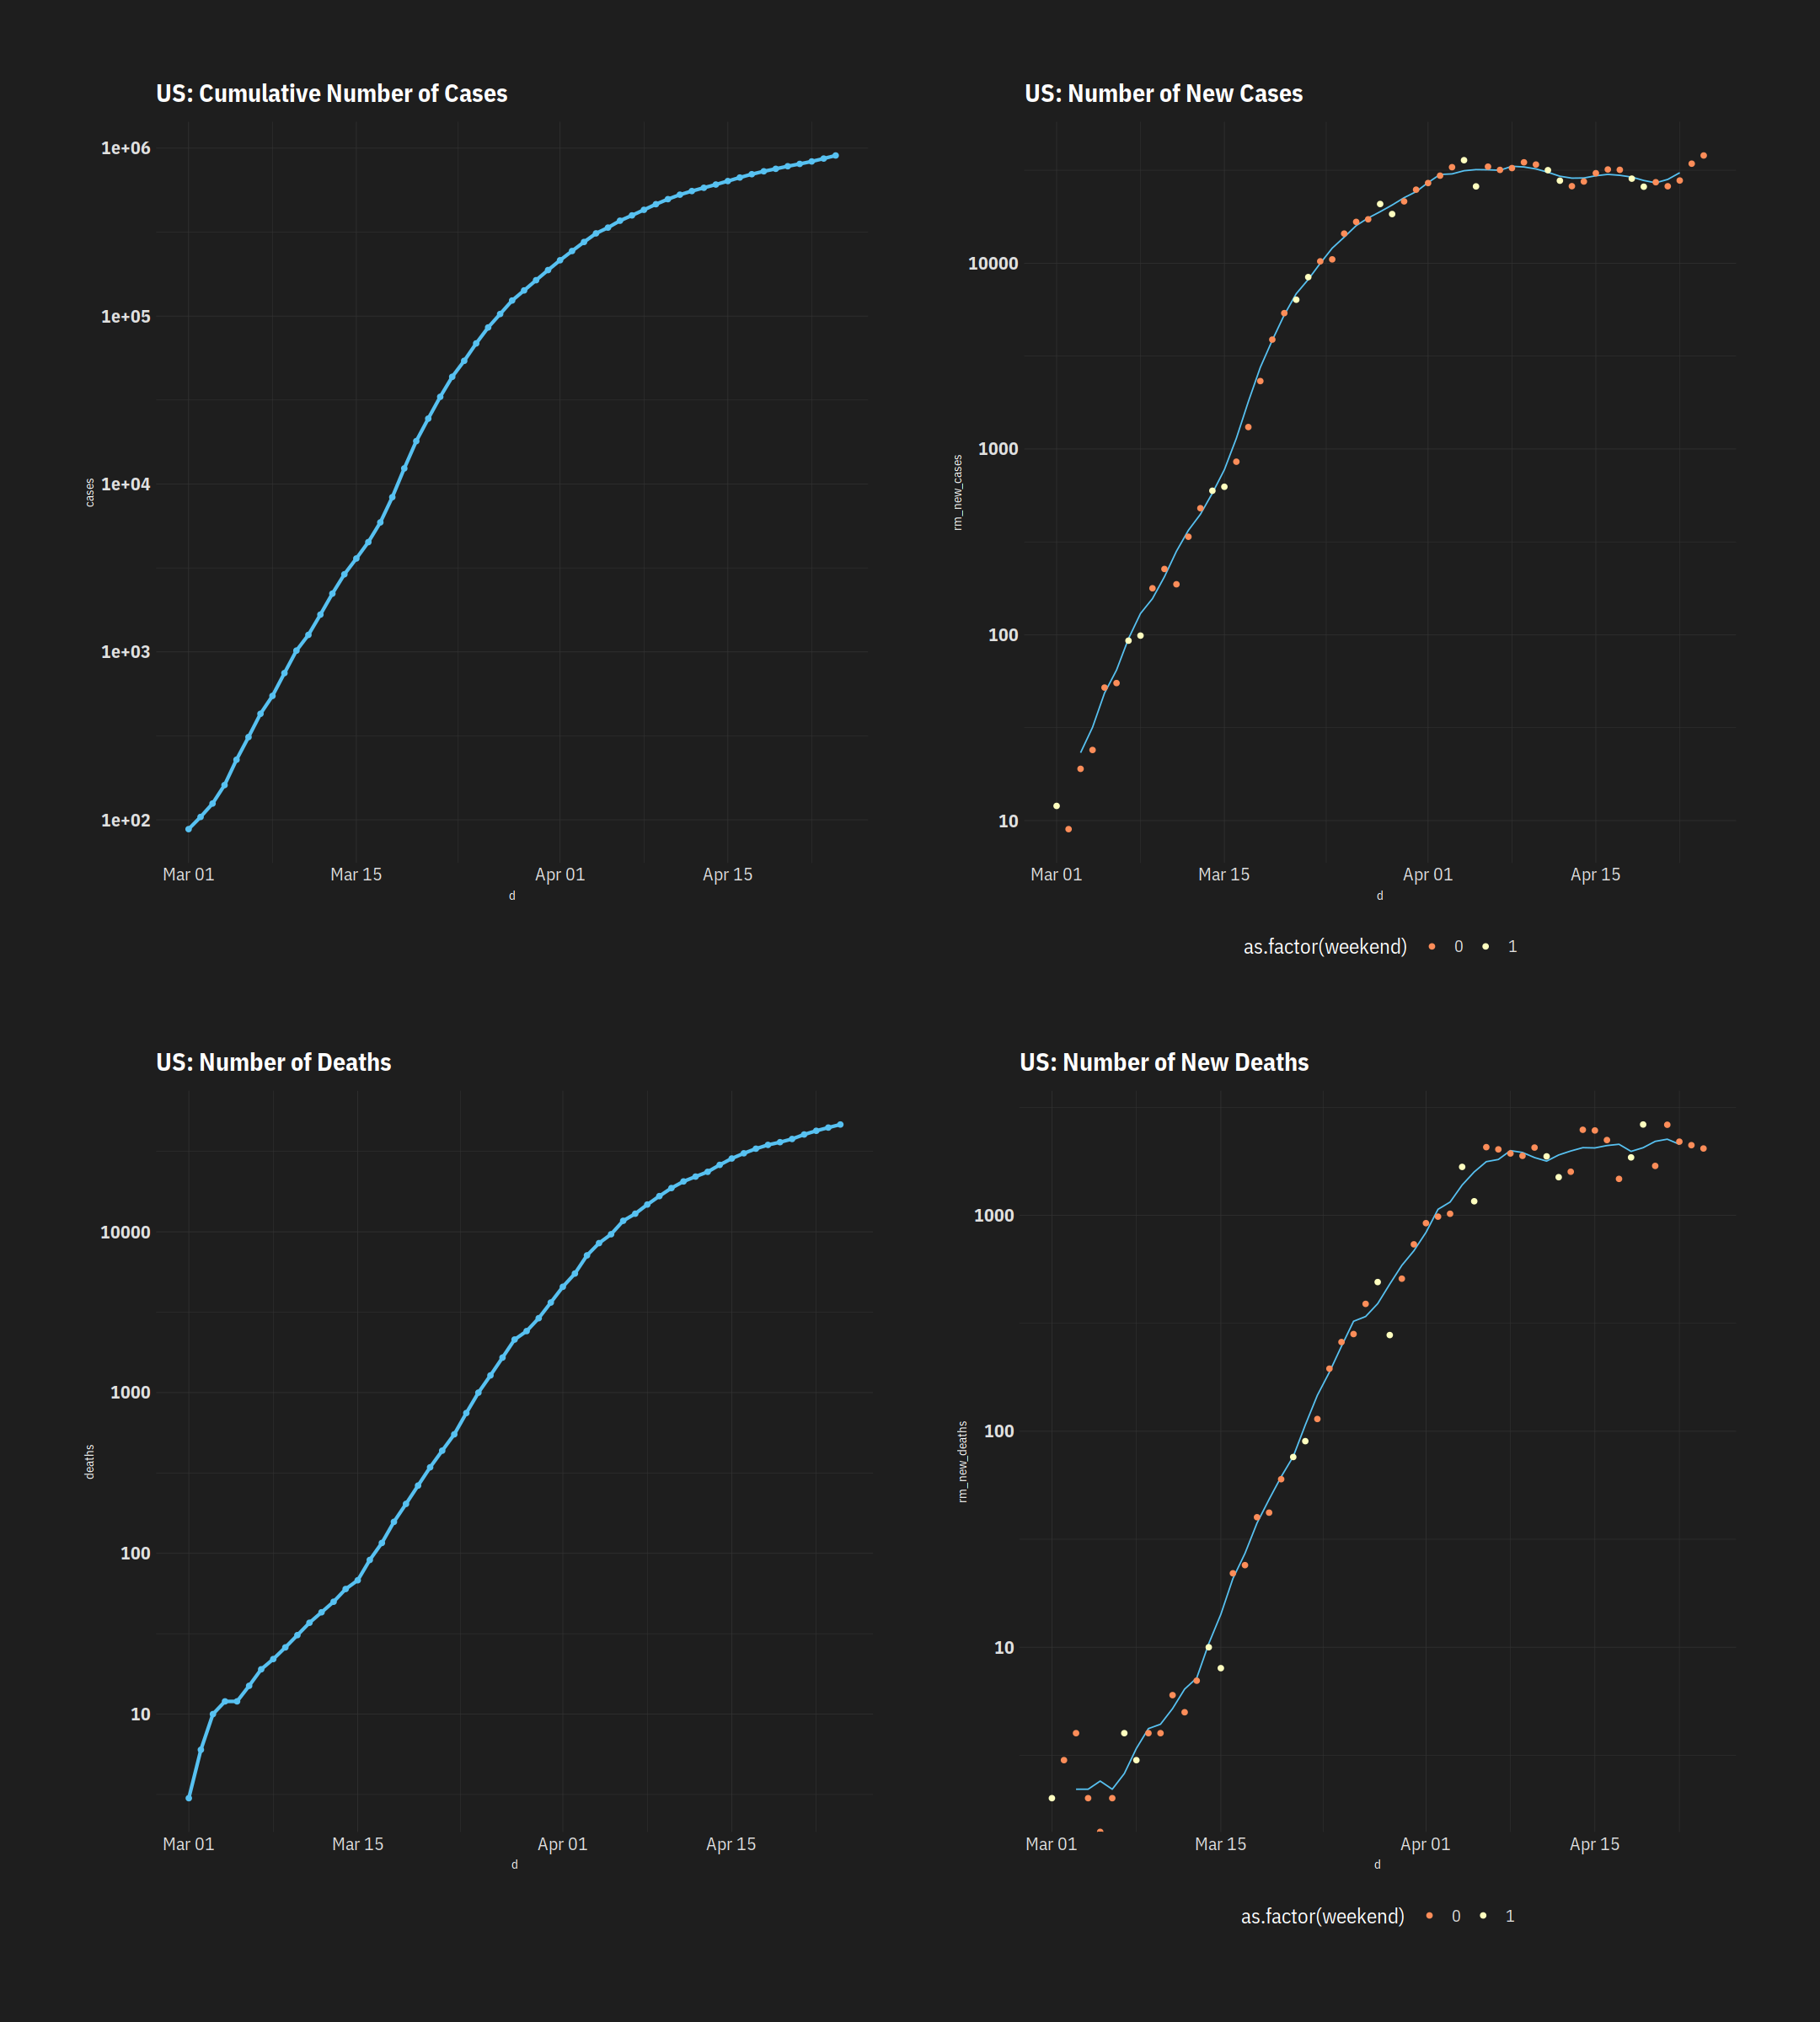

In [8]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(npan, aes(x = d, y = cases)) +
  geom_line(size = 1.2) + geom_point()+ 
  scale_y_log10() +
  ggtitle("US: Cumulative Number of Cases")

p11 = ggplot(npan, aes(x = d)) +
  geom_line(aes(y = rm_new_cases)) +
  geom_point(aes(y = new_cases, colour = as.factor(weekend))) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("US: Number of New Cases")

p2 = ggplot(npan, aes(x = d, y = deaths)) +
  geom_line(size = 1.2) + geom_point() +
  scale_y_log10() +
  ggtitle("US: Number of Deaths")

p22 = ggplot(npan, aes(x = d)) +
  geom_line(aes(y = rm_new_deaths)) +
  geom_point(aes(y = new_deaths, colour = as.factor(weekend))) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("US: Number of New Deaths")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

## State Panel 

In [9]:
stpan = df[, lapply(.SD, sum, na.rm = T), by = .(state, d), .SDcols = rawvars]
(t10 = stpan[d == max(d)][order(-cases)][1:10])
stpan = rollmeaneR(stpan, grouping = "state")
stpan[, cfr := deaths/cases]

state         d          cases  deaths new_cases new_deaths
1  New York      2020-04-24 271621 16162  8161      422       
2  New Jersey    2020-04-24 102196  5617  2783      252       
3  Massachusetts 2020-04-24  50969  2556  4946      196       
4  California    2020-04-24  41368  1619  1834       81       
5  Pennsylvania  2020-04-24  40298  1786  1964       73       
6  Illinois      2020-04-24  39658  1804  2726      108       
7  Michigan      2020-04-24  36628  3084  1377      107       
8  Florida       2020-04-24  30525  1045   886       59       
9  Louisiana     2020-04-24  26140  1601   405       62       
10 Connecticut   2020-04-24  23921  1764   836      129

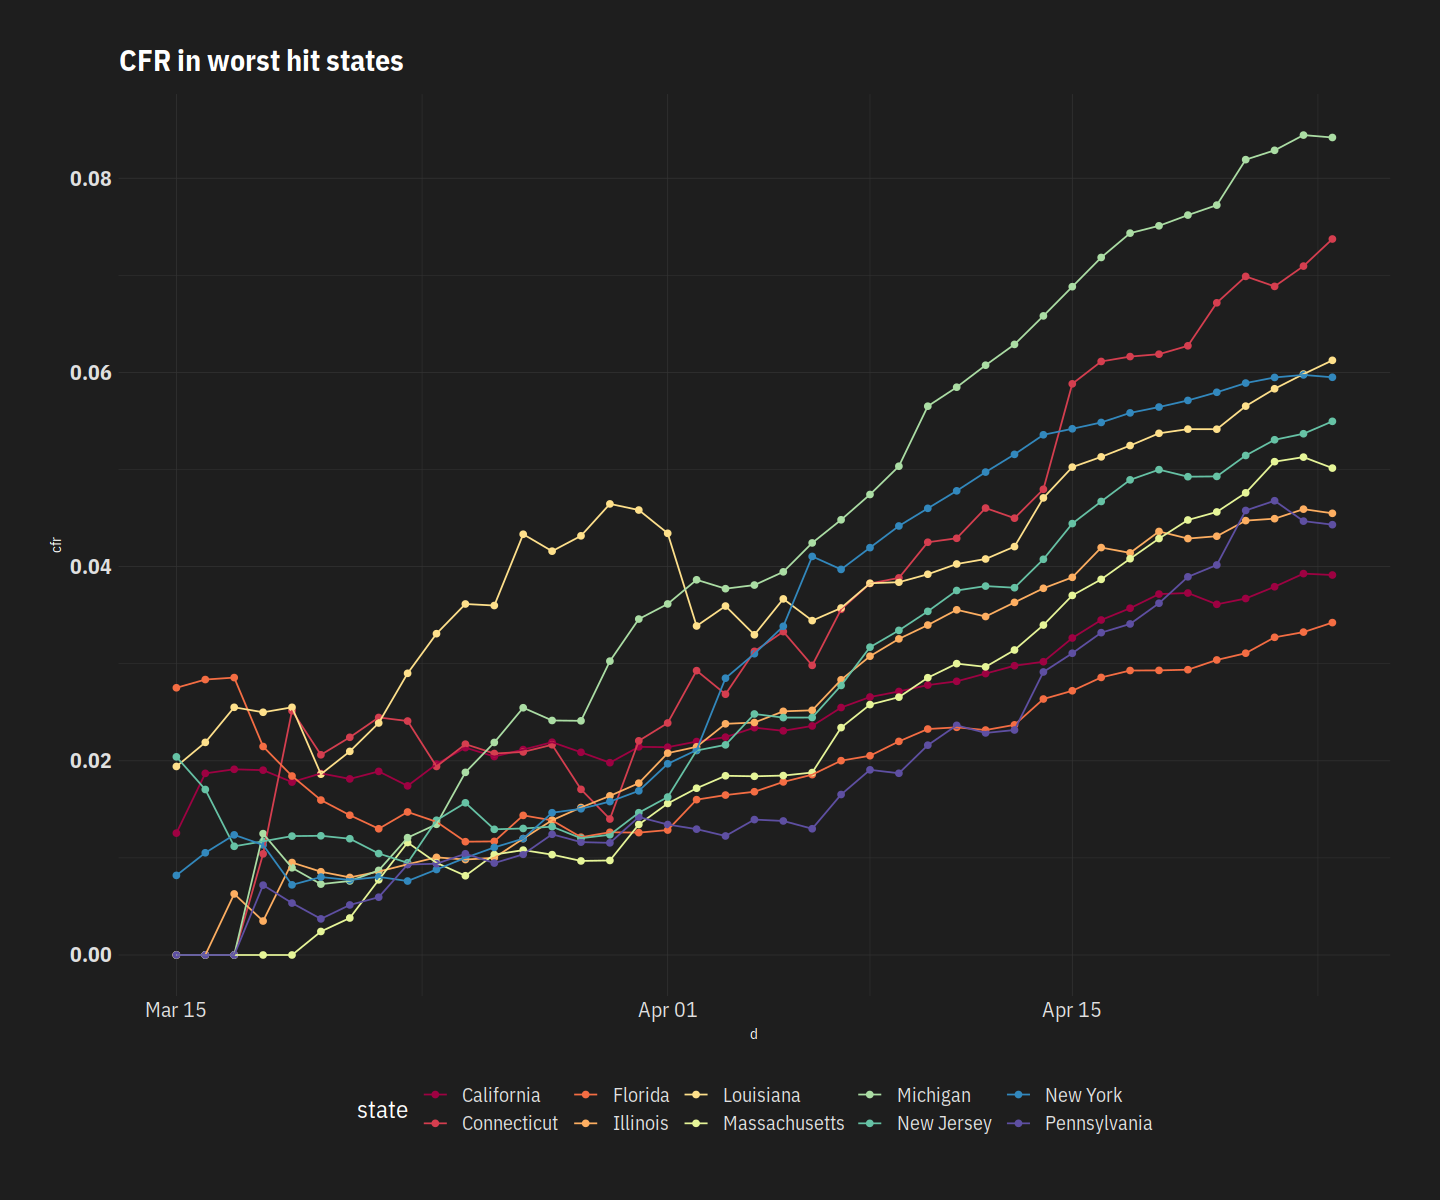

In [10]:
options(repr.plot.width = 12, repr.plot.height=10)
ggplot(stpan[state %in% t10$state & d >= "2020-03-15"], aes(x = d, y = cfr, group = state, colour = state)) +
  geom_point() + geom_line() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("CFR in worst hit states")

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 40 row(s) containing missing values (geom_path).”


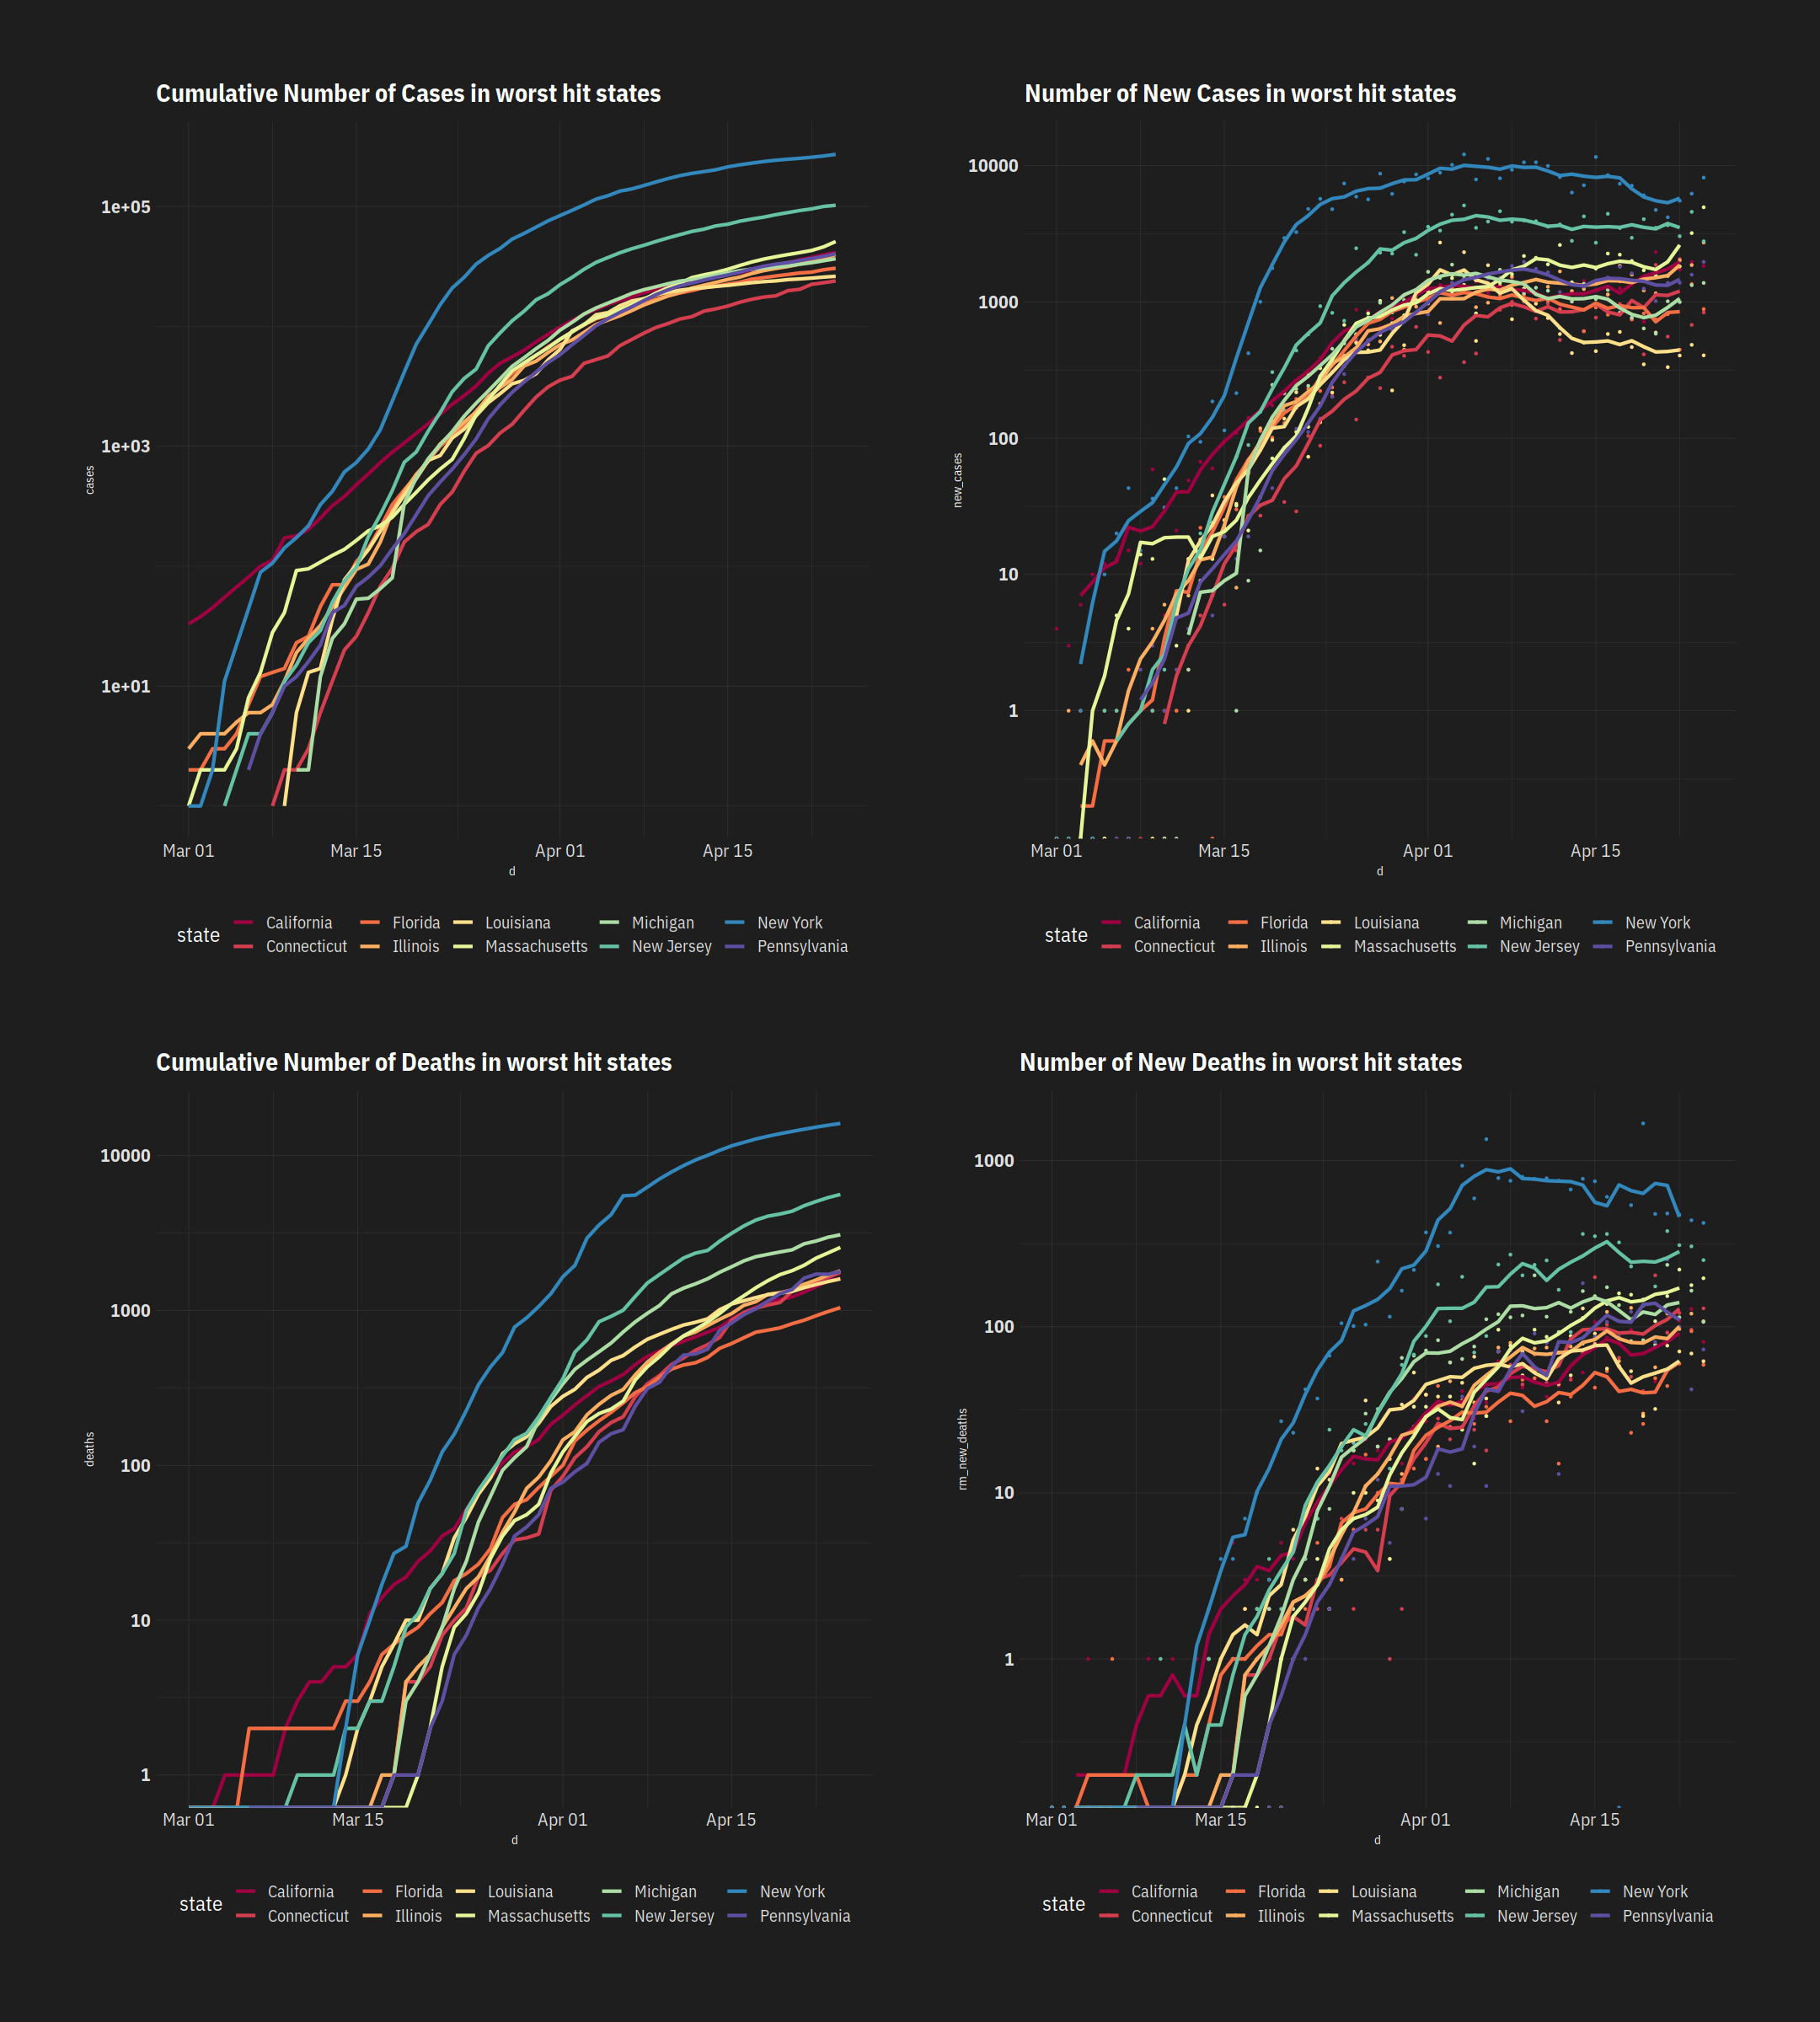

In [11]:
options(repr.plot.width = 20, repr.plot.height=16)
p1 = ggplot(stpan[state %in% t10$state], aes(x = d, y = cases, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Cases in worst hit states")

p11 = ggplot(stpan[state %in% t10$state], aes(x = d, group = state, colour = state)) +
  geom_point(aes(y = new_cases), size = 0.6) +
  geom_line(aes(y = rm_new_cases), size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Cases in worst hit states")

p2 = ggplot(stpan[state %in% t10$state], aes(x = d, y = deaths, group = state, colour = state)) +
  geom_line(size = 1.2) +
  scale_y_log10() +
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Cumulative Number of Deaths in worst hit states")

p22 = ggplot(stpan[state %in% t10$state], aes(x = d, y = rm_new_deaths, group = state, colour = state)) +
  geom_point(aes(y = new_deaths), size = 0.6) +
  geom_line(aes(y = rm_new_deaths), size = 1.2) +
  scale_y_log10() + 
  scale_colour_brewer(palette = "Spectral") + 
  ggtitle("Number of New Deaths in worst hit states")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p11) /( p2 | p22)

## CA: Bay Area vs the rest

In [12]:
bay_counties = c(
  "San Francisco", "San Mateo", "Santa Clara",
  "Alameda", "Contra Costa", "Marin", 
  "Napa", "Solano", "Sonoma"
)

In [13]:
ca_all = df[state == "California"]
ca_all[, bayrea := case_when(
    county %in% bay_counties ~ "Bay",
    TRUE ~ "Elsewhere")]
vars = c("cases", "deaths", "new_cases", "new_deaths")
ca_div = ca_all[, lapply(.SD, sum, na.rm = T), 
   by = .(bayrea, d), .SDcols = vars]

ca_div %>% head

bayrea d          cases deaths new_cases new_deaths
1 Bay    2020-03-01 26    0      4         0         
2 Bay    2020-03-02 30    0      3         0         
3 Bay    2020-03-03 34    0      3         0         
4 Bay    2020-03-04 38    0      4         0         
5 Bay    2020-03-05 46    0      8         0         
6 Bay    2020-03-06 54    0      8         0

In [14]:
ca_div = rollmeaneR(ca_div, grouping = 'bayrea')

kvs = c("cases", "deaths", "new_cases", "new_deaths")
(cur = ca_div[order(-d), .SD[1], by = bayrea, .SDcols = kvs])
cur[, (deaths / cases)]
cur[, lapply(.SD, sum, na.rm = T), .SDcols = kvs]

bayrea    cases deaths new_cases new_deaths
1 Bay        7244  253    186       7        
2 Elsewhere 34124 1366   1648      74

[1] 0.03493 0.04003

cases deaths new_cases new_deaths
1 41368 1619   1834      81

Warning message:
“Removed 8 row(s) containing missing values (geom_path).”
Warning message:
“Removed 8 row(s) containing missing values (geom_path).”


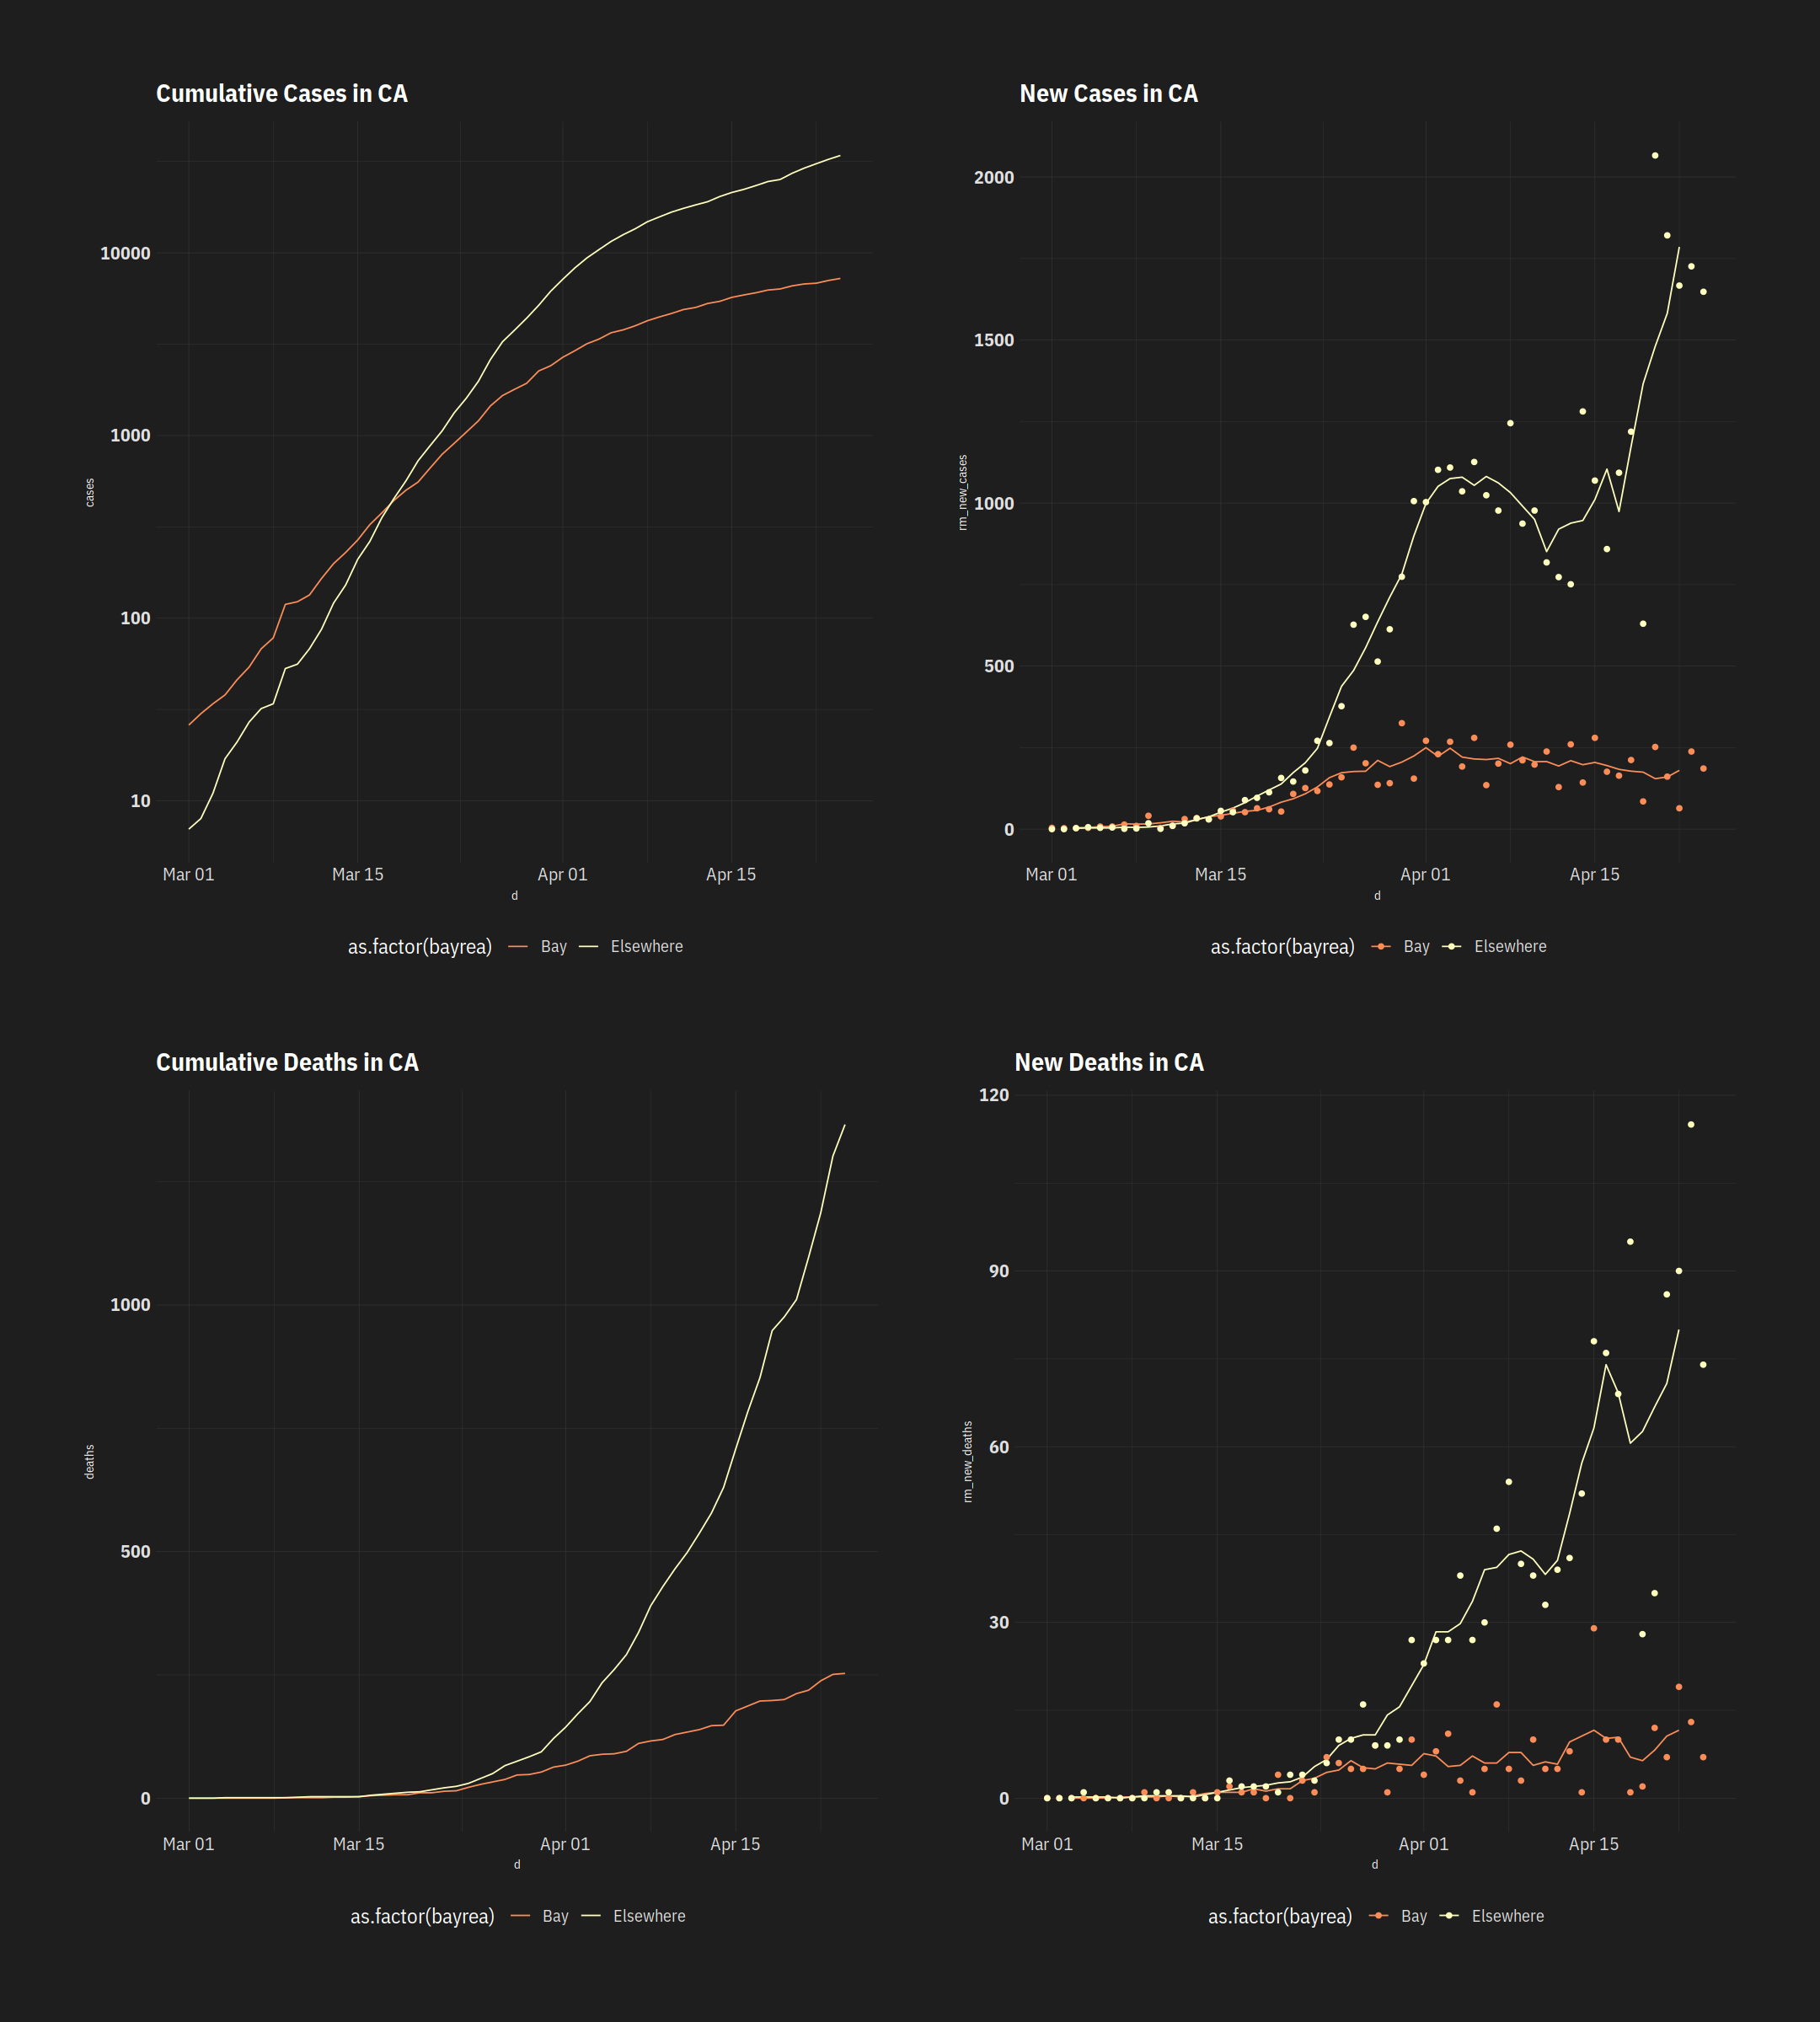

In [15]:
p1 = ggplot(ca_div, aes(x = d, y = cases, group = as.factor(bayrea), colour = as.factor(bayrea))) +
    geom_line() + scale_y_log10()+
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Cases in CA")
p2 = ggplot(ca_div, aes(x = d,  group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line(aes(y = rm_new_cases)) +
  geom_point(aes(y = new_cases)) +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Cases in CA")

p3 = ggplot(ca_div, aes(x = d, y = deaths, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line() +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("Cumulative Deaths in CA")

p4 = ggplot(ca_div, aes(x = d, y = rm_new_deaths, group = as.factor(bayrea), colour = as.factor(bayrea))) +
  geom_line(aes(y = rm_new_deaths)) +
  geom_point(aes(y = new_deaths)) +
  scale_colour_brewer(palette = 'Spectral') +
    ggtitle("New Deaths in CA")

options(repr.plot.width = 18, repr.plot.height=20)
(p1 | p2) / (p3 | p4)

## Counties within the Bay Area

In [16]:
bayrea_mar = rollmeaneR(df[county %in% bay_counties & state == "California" & d>= "2020-03-01"])
bayrea_mar %>% glimpse

Rows: 492
Columns: 14
$ date          <chr> "2020-03-01", "2020-03-02", "2020-03-03", "2020-03-04",…
$ county        <chr> "Alameda", "Alameda", "Alameda", "Alameda", "Alameda", …
$ state         <chr> "California", "California", "California", "California",…
$ fips          <int> 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6001, 6…
$ cases         <int> 1, 1, 2, 2, 2, 3, 3, 3, 24, 25, 25, 29, 29, 29, 37, 40,…
$ deaths        <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ d             <date> 2020-03-01, 2020-03-02, 2020-03-03, 2020-03-04, 2020-0…
$ cfr           <dbl> 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000…
$ new_cases     <dbl> NA, 0, 1, 0, 0, 1, 0, 0, 21, 1, 0, 4, 0, 0, 8, 3, 9, 4,…
$ new_deaths    <dbl> NA, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ rm_cases      <dbl> NA, NA, 1.6, 2.0, 2.4, 2.6, 7.0, 11.6, 16.0, 21.2, 26.4…
$ rm_deaths     <dbl> NA, NA, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.…
$ rm_new_cases  <dbl> NA, NA, 

### Cases

In [17]:
bayrea_mar[, cfr := deaths/cases]

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 39 row(s) containing missing values (geom_path).”


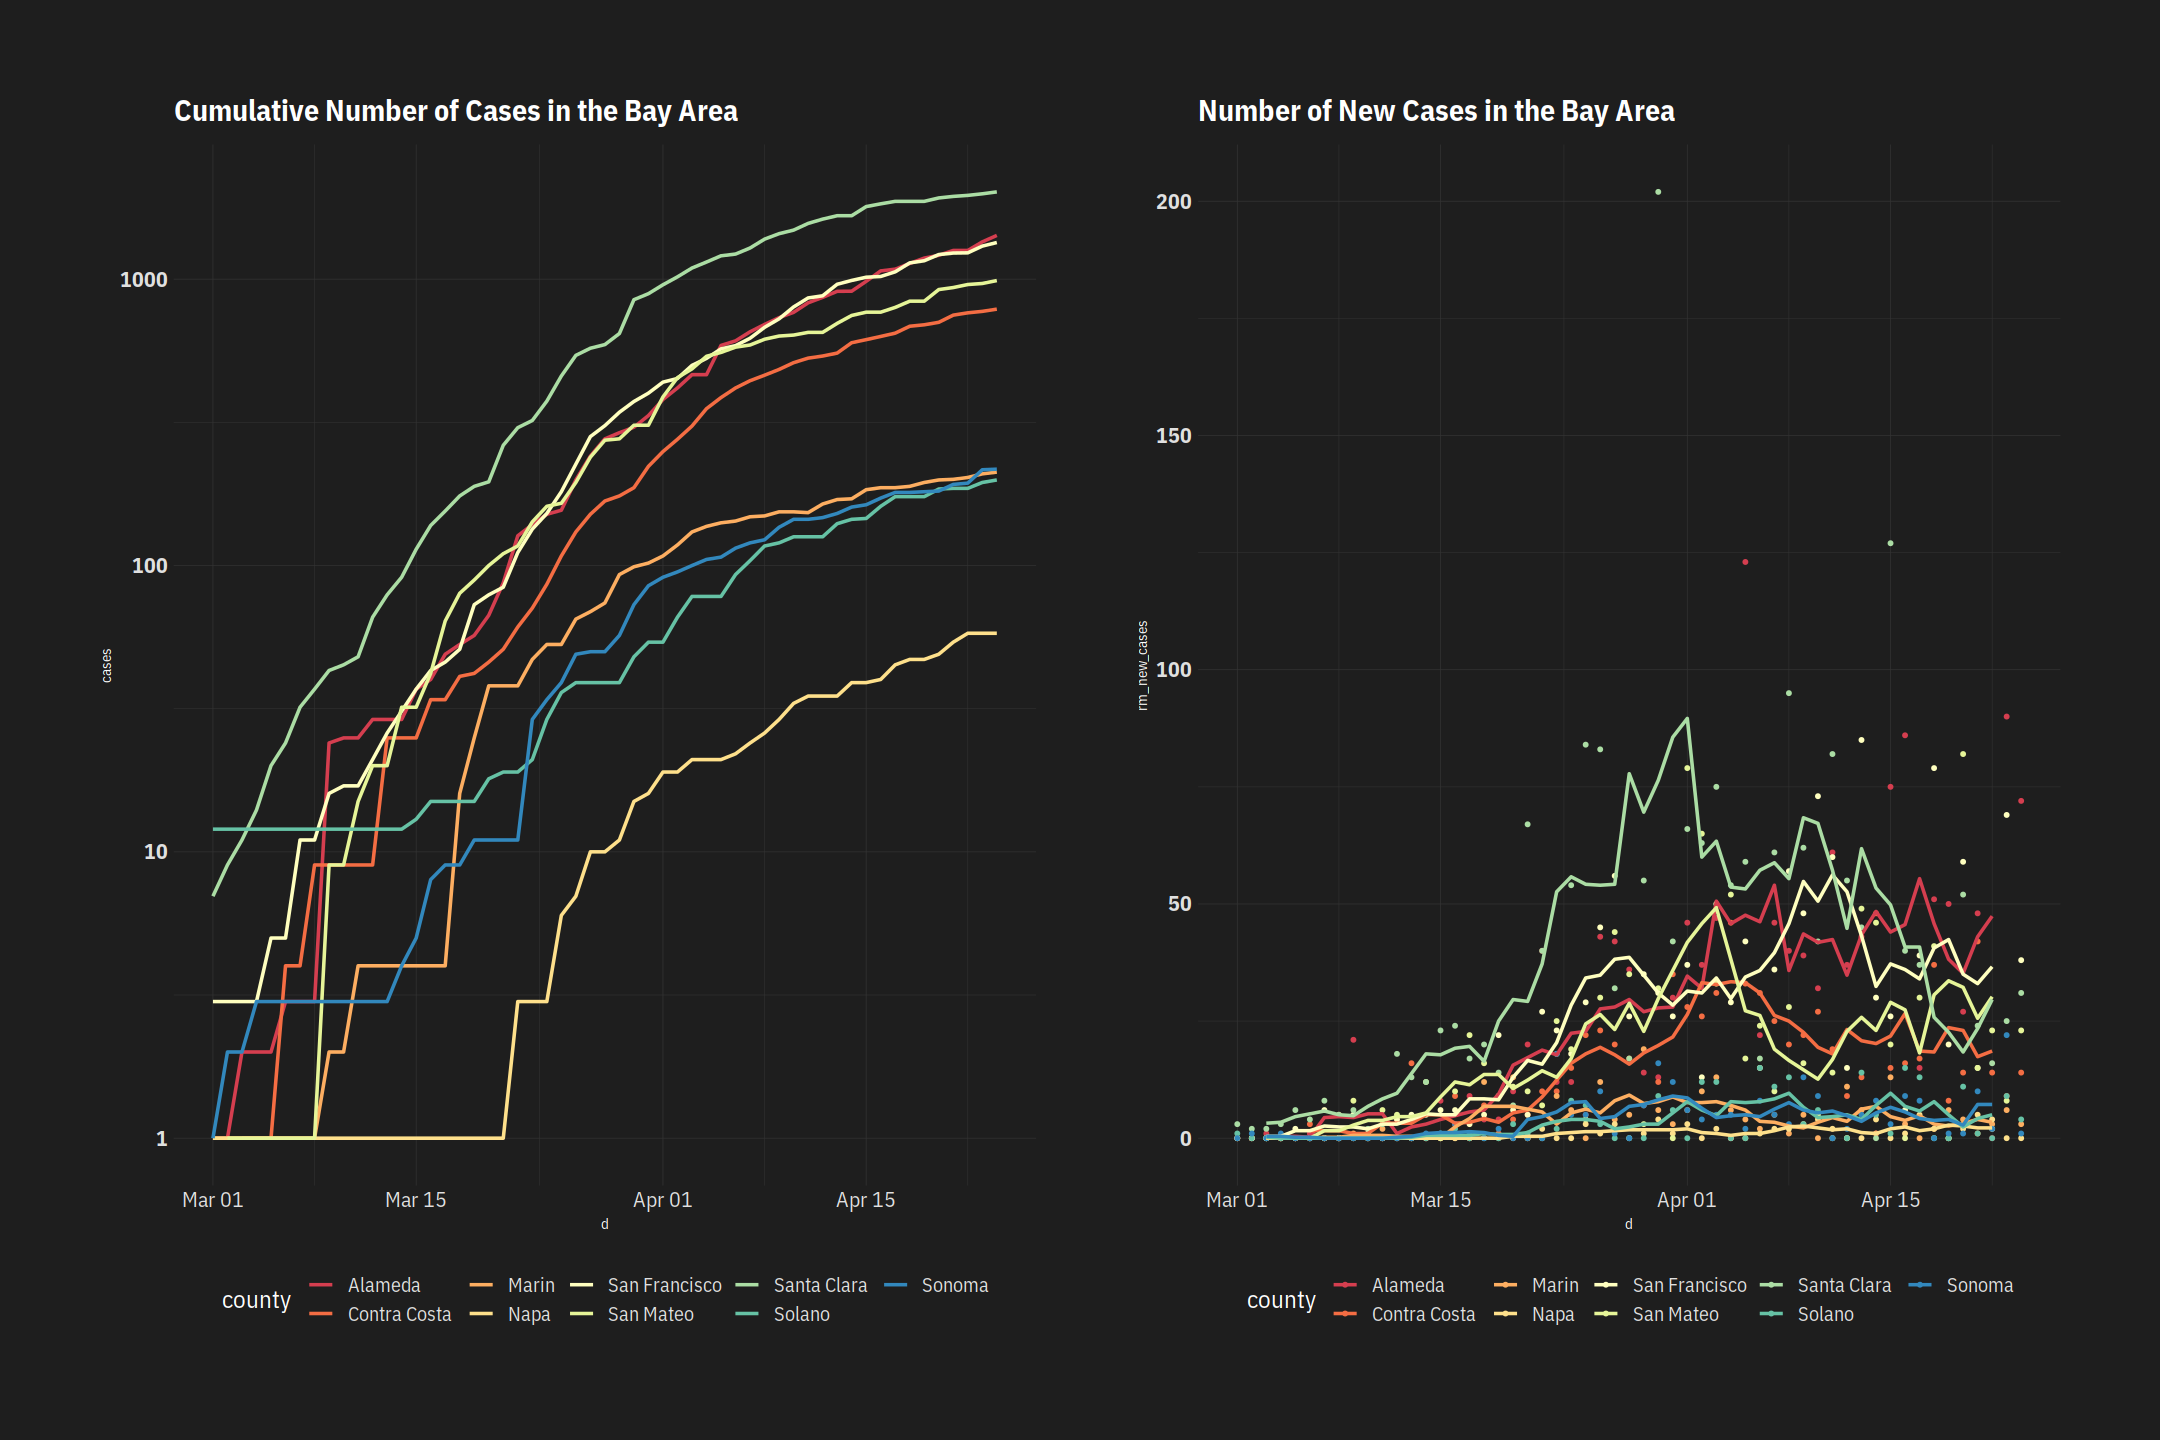

In [18]:
p1 = ggplot(bayrea_mar, aes(x = d, y = cases, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_y_log10() +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Cases in the Bay Area")

p2 = ggplot(bayrea_mar, aes(x = d, y = rm_new_cases, group = county, colour = county)) +
  geom_point(aes(y = new_cases), size = 1) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Cases in the Bay Area")
options(repr.plot.width = 18, repr.plot.height=12)
(p1 | p2)

Warning message:
“Removed 3 rows containing missing values (geom_point).”
Warning message:
“Removed 39 row(s) containing missing values (geom_path).”


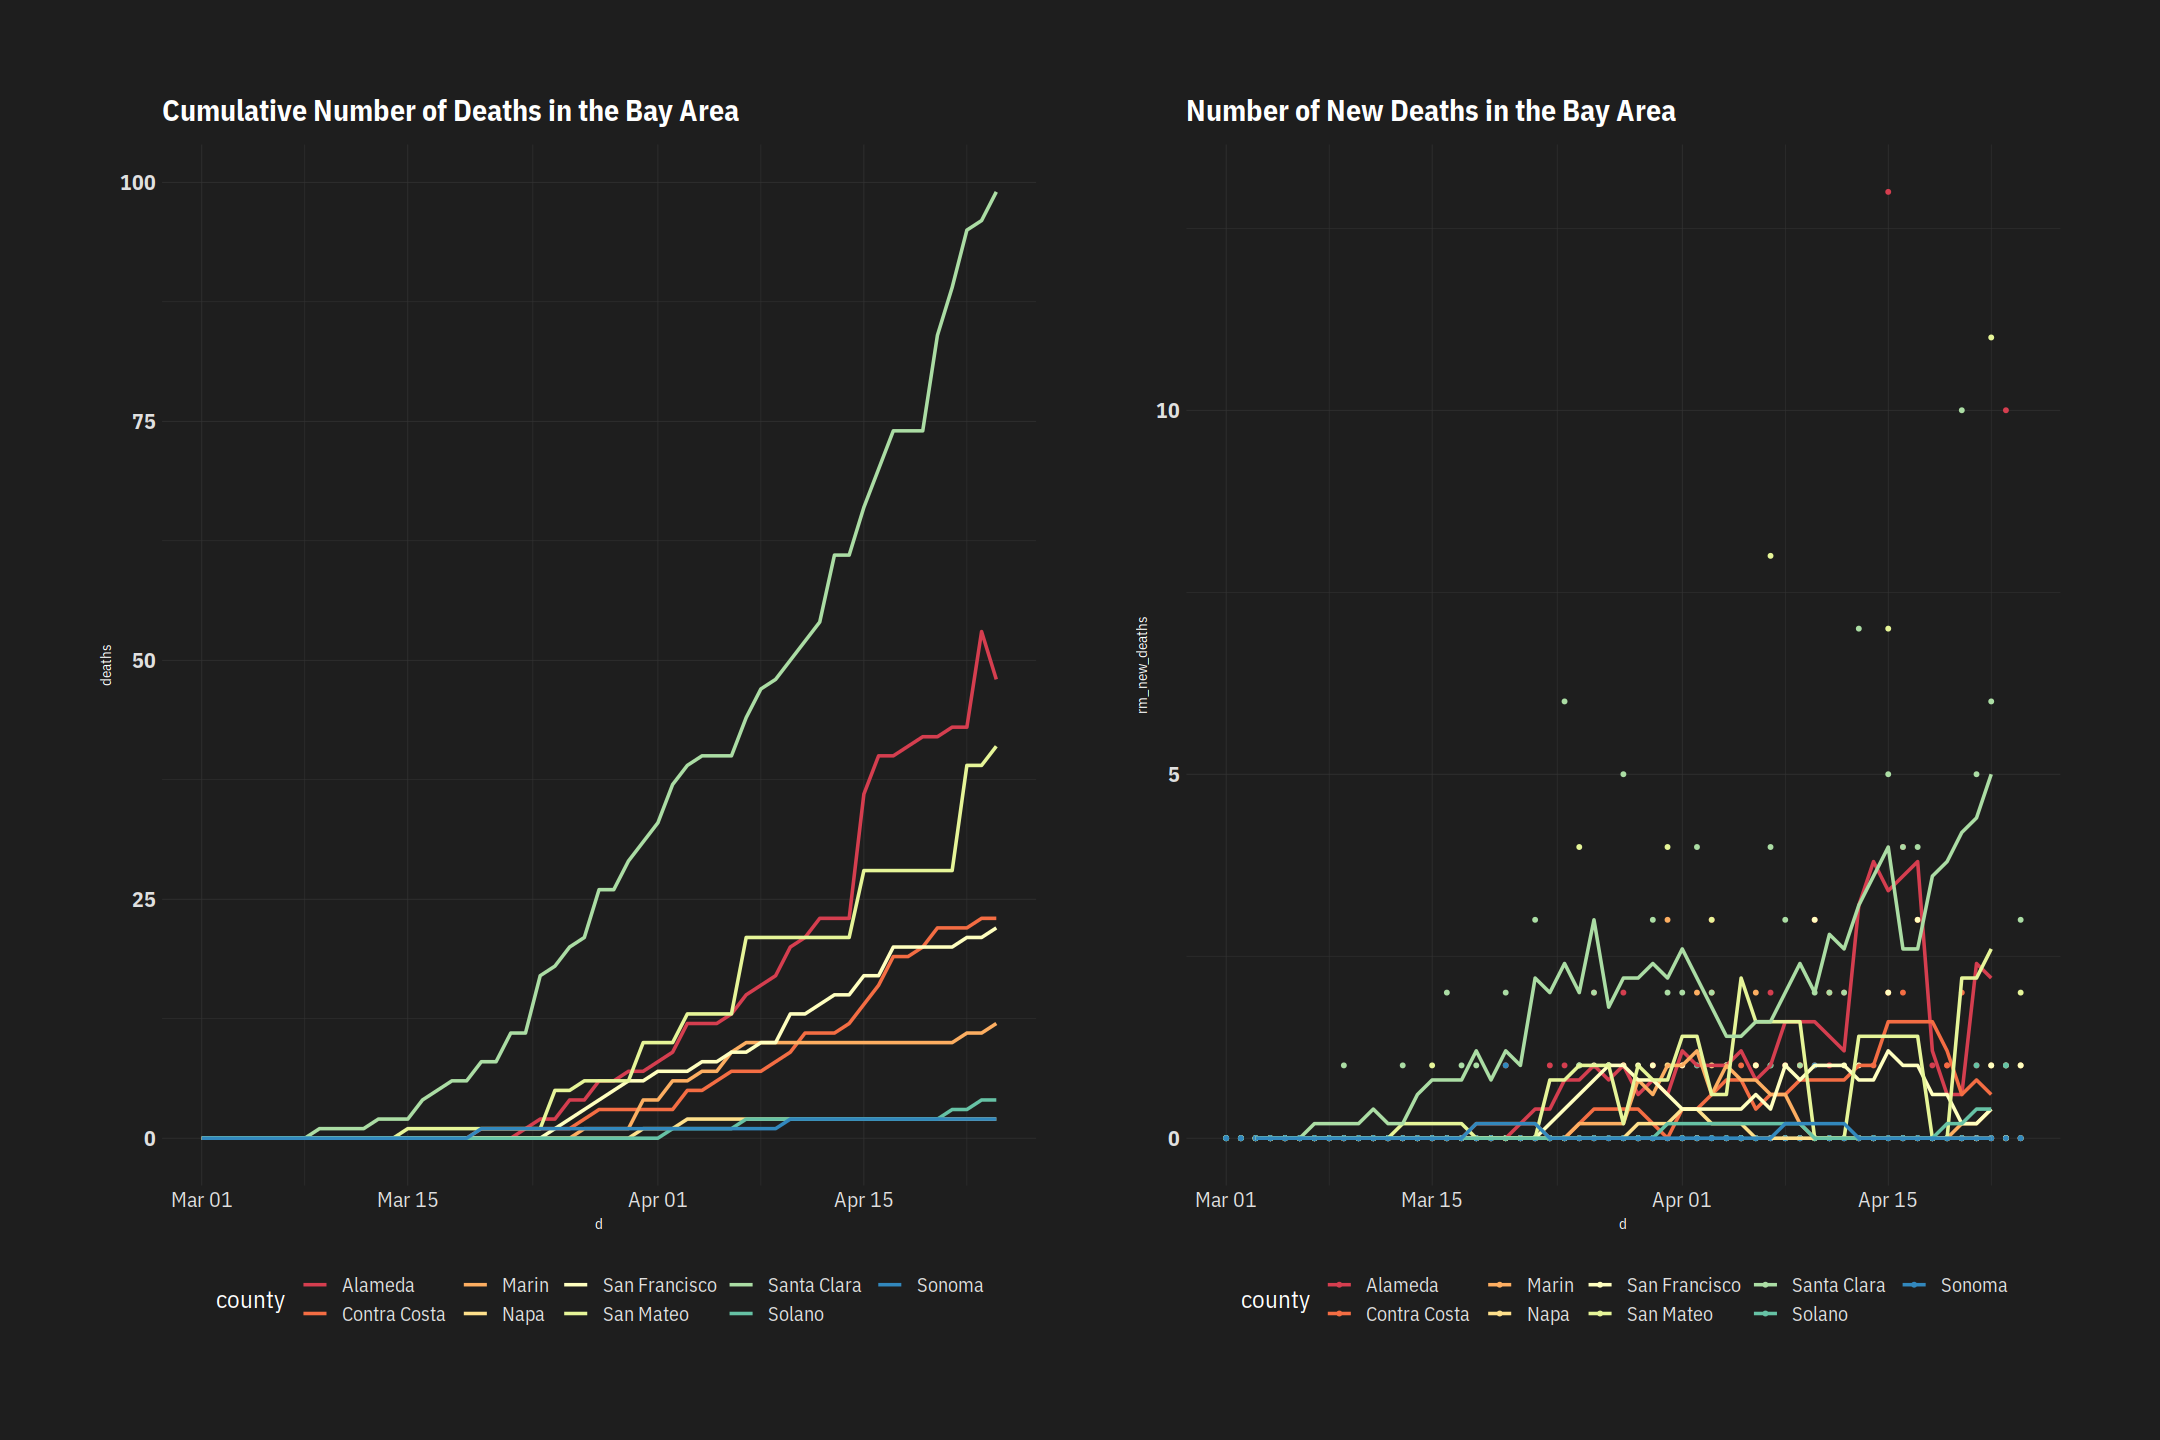

In [19]:
p1 = ggplot(bayrea_mar, aes(x = d, y = deaths, group = county, colour = county)) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Cumulative Number of Deaths in the Bay Area")
p2 = ggplot(bayrea_mar, aes(x = d, y = rm_new_deaths, group = county, colour = county)) +
  geom_point(aes(y = new_deaths), size = 1) +
  geom_line(size = 1) +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("Number of New Deaths in the Bay Area")
(p1 | p2)

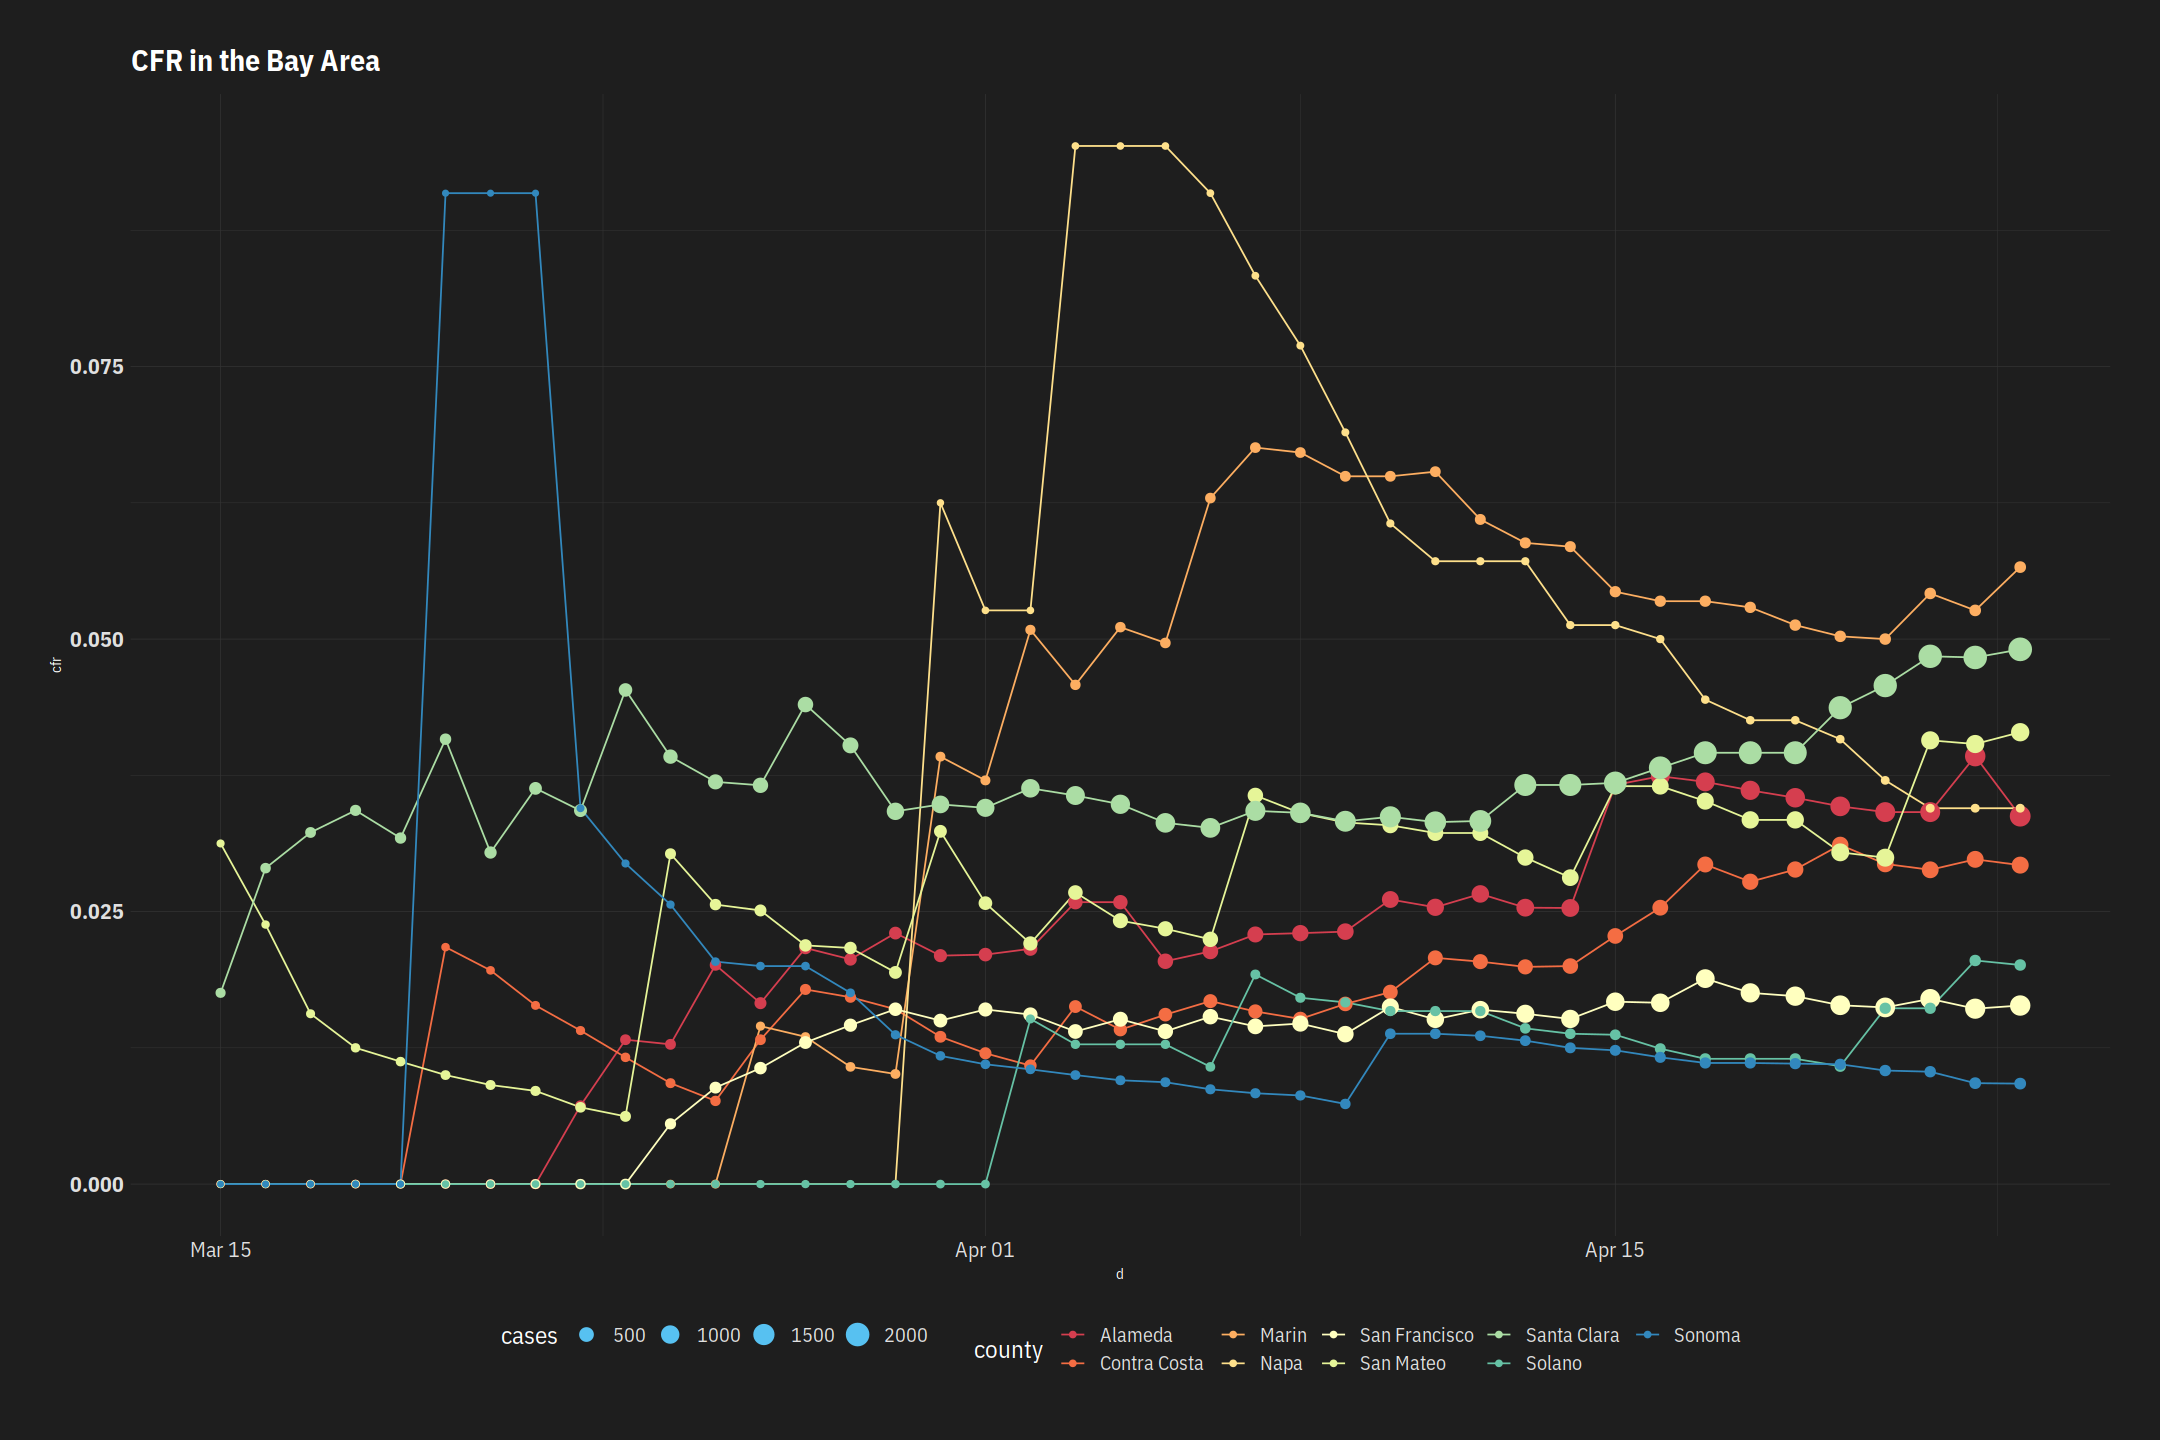

In [20]:
(cfrp = ggplot(bayrea_mar[d >= "2020-03-15"], aes(x = d, y = cfr, group = county, colour = county )) +
  geom_line()  +
  scale_colour_brewer(palette = 'Spectral') +
  ggtitle("CFR in the Bay Area")
) + geom_point(aes(size = cases))

In [21]:
embed_notebook(ggplotly(cfrp + geom_point()))

Warning message:
“`group_by_()` is deprecated as of dplyr 0.7.0.
Please use `group_by()` instead.
See vignette('programming') for more help
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


<iframe src="data:text/html;charset=utf-8;base64,PCFET0NUWVBFIGh0bWw+CjxodG1sPgo8aGVhZD4KPG1ldGEgY2hhcnNldD0idXRmLTgiIC8+Cjx0aXRsZT5wbG90bHk8L3RpdGxlPgo8c2NyaXB0PihmdW5jdGlvbigpIHsKICAvLyBJZiB3aW5kb3cuSFRNTFdpZGdldHMgaXMgYWxyZWFkeSBkZWZpbmVkLCB0aGVuIHVzZSBpdDsgb3RoZXJ3aXNlIGNyZWF0ZSBhCiAgLy8gbmV3IG9iamVjdC4gVGhpcyBhbGxvd3MgcHJlY2VkaW5nIGNvZGUgdG8gc2V0IG9wdGlvbnMgdGhhdCBhZmZlY3QgdGhlCiAgLy8gaW5pdGlhbGl6YXRpb24gcHJvY2VzcyAodGhvdWdoIG5vbmUgY3VycmVudGx5IGV4aXN0KS4KICB3aW5kb3cuSFRNTFdpZGdldHMgPSB3aW5kb3cuSFRNTFdpZGdldHMgfHwge307CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIGEgdmlld2VyIHBhbmUuIElmIG5vdCwgd2UncmUgaW4gYSB3ZWIgYnJvd3Nlci4KICB2YXIgdmlld2VyTW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy52aWV3ZXJNb2RlID0KICAgICAgL1xidmlld2VyX3BhbmU9MVxiLy50ZXN0KHdpbmRvdy5sb2NhdGlvbik7CgogIC8vIFNlZSBpZiB3ZSdyZSBydW5uaW5nIGluIFNoaW55IG1vZGUuIElmIG5vdCwgaXQncyBhIHN0YXRpYyBkb2N1bWVudC4KICAvLyBOb3RlIHRoYXQgc3RhdGljIHdpZGdldHMgY2FuIGFwcGVhciBpbiBib3RoIFNoaW55IGFuZCBzdGF0aWMgbW9kZXMsIGJ1dAogIC8vIG9idmlvdXNseSwgU2hpbnkgd2lkZ2V0cyBjYW4gb25seSBhcHBlYXIgaW4gU2hpbnkgYXBwcy9kb2N1bWVudHMuCiAgdmFyIHNoaW55TW9kZSA9IHdpbmRvdy5IVE1MV2lkZ2V0cy5zaGlueU1vZGUgPQogICAgICB0eXBlb2Yod2luZG93LlNoaW55KSAhPT0gInVuZGVmaW5lZCIgJiYgISF3aW5kb3cuU2hpbnkub3V0cHV0QmluZGluZ3M7CgogIC8vIFdlIGNhbid0IGNvdW50IG9uIGpRdWVyeSBiZWluZyBhdmFpbGFibGUsIHNvIHdlIGltcGxlbWVudCBvdXIgb3duCiAgLy8gdmVyc2lvbiBpZiBuZWNlc3NhcnkuCiAgZnVuY3Rpb24gcXVlcnlTZWxlY3RvckFsbChzY29wZSwgc2VsZWN0b3IpIHsKICAgIGlmICh0eXBlb2YoalF1ZXJ5KSAhPT0gInVuZGVmaW5lZCIgJiYgc2NvcGUgaW5zdGFuY2VvZiBqUXVlcnkpIHsKICAgICAgcmV0dXJuIHNjb3BlLmZpbmQoc2VsZWN0b3IpOwogICAgfQogICAgaWYgKHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwpIHsKICAgICAgcmV0dXJuIHNjb3BlLnF1ZXJ5U2VsZWN0b3JBbGwoc2VsZWN0b3IpOwogICAgfQogIH0KCiAgZnVuY3Rpb24gYXNBcnJheSh2YWx1ZSkgewogICAgaWYgKHZhbHVlID09PSBudWxsKQogICAgICByZXR1cm4gW107CiAgICBpZiAoJC5pc0FycmF5KHZhbHVlKSkKICAgICAgcmV0dXJuIHZhbHVlOwogICAgcmV0dXJuIFt2YWx1ZV07CiAgfQoKICAvLyBJbXBsZW1lbnQgalF1ZXJ5J3MgZXh0ZW5kCiAgZnVuY3Rpb24gZXh0ZW5kKHRhcmdldCAvKiwgLi4uICovKSB7CiAgICBpZiAoYXJndW1lbnRzLmxlbmd0aCA9PSAxKSB7CiAgICAgIHJldHVybiB0YXJnZXQ7CiAgICB9CiAgICBmb3IgKHZhciBpID0gMTsgaSA8IGFyZ3VtZW50cy5sZW5ndGg7IGkrKykgewogICAgICB2YXIgc291cmNlID0gYXJndW1lbnRzW2ldOwogICAgICBmb3IgKHZhciBwcm9wIGluIHNvdXJjZSkgewogICAgICAgIGlmIChzb3VyY2UuaGFzT3duUHJvcGVydHkocHJvcCkpIHsKICAgICAgICAgIHRhcmdldFtwcm9wXSA9IHNvdXJjZVtwcm9wXTsKICAgICAgICB9CiAgICAgIH0KICAgIH0KICAgIHJldHVybiB0YXJnZXQ7CiAgfQoKICAvLyBJRTggZG9lc24ndCBzdXBwb3J0IEFycmF5LmZvckVhY2guCiAgZnVuY3Rpb24gZm9yRWFjaCh2YWx1ZXMsIGNhbGxiYWNrLCB0aGlzQXJnKSB7CiAgICBpZiAodmFsdWVzLmZvckVhY2gpIHsKICAgICAgdmFsdWVzLmZvckVhY2goY2FsbGJhY2ssIHRoaXNBcmcpOwogICAgfSBlbHNlIHsKICAgICAgZm9yICh2YXIgaSA9IDA7IGkgPCB2YWx1ZXMubGVuZ3RoOyBpKyspIHsKICAgICAgICBjYWxsYmFjay5jYWxsKHRoaXNBcmcsIHZhbHVlc1tpXSwgaSwgdmFsdWVzKTsKICAgICAgfQogICAgfQogIH0KCiAgLy8gUmVwbGFjZXMgdGhlIHNwZWNpZmllZCBtZXRob2Qgd2l0aCB0aGUgcmV0dXJuIHZhbHVlIG9mIGZ1bmNTb3VyY2UuCiAgLy8KICAvLyBOb3RlIHRoYXQgZnVuY1NvdXJjZSBzaG91bGQgbm90IEJFIHRoZSBuZXcgbWV0aG9kLCBpdCBzaG91bGQgYmUgYSBmdW5jdGlvbgogIC8vIHRoYXQgUkVUVVJOUyB0aGUgbmV3IG1ldGhvZC4gZnVuY1NvdXJjZSByZWNlaXZlcyBhIHNpbmdsZSBhcmd1bWVudCB0aGF0IGlzCiAgLy8gdGhlIG92ZXJyaWRkZW4gbWV0aG9kLCBpdCBjYW4gYmUgY2FsbGVkIGZyb20gdGhlIG5ldyBtZXRob2QuIFRoZSBvdmVycmlkZGVuCiAgLy8gbWV0aG9kIGNhbiBiZSBjYWxsZWQgbGlrZSBhIHJlZ3VsYXIgZnVuY3Rpb24sIGl0IGhhcyB0aGUgdGFyZ2V0IHBlcm1hbmVudGx5CiAgLy8gYm91bmQgdG8gaXQgc28gInRoaXMiIHdpbGwgd29yayBjb3JyZWN0bHkuCiAgZnVuY3Rpb24gb3ZlcnJpZGVNZXRob2QodGFyZ2V0LCBtZXRob2ROYW1lLCBmdW5jU291cmNlKSB7CiAgICB2YXIgc3VwZXJGdW5jID0gdGFyZ2V0W21ldGhvZE5hbWVdIHx8IGZ1bmN0aW9uKCkge307CiAgICB2YXIgc3VwZXJGdW5jQm91bmQgPSBmdW5jdGlvbigpIHsKICAgICAgcmV0dXJuIHN1cGVyRnVuYy5hcHBseSh0YXJnZXQsIGFyZ3VtZW50cyk7CiAgICB9OwogICAgdGFyZ2V0W21ldGhvZE5hbWVdID0gZnVuY1NvdXJjZShzdXBlckZ1bmNCb3VuZCk7CiAgfQoKICAvLyBBZGQgYSBtZXRob2QgdG8gZGVsZWdhdG9yIHRoYXQsIHdoZW4gaW52b2tlZCwgY2FsbHMKICAvLyBkZWxlZ2F0ZWUubWV0aG9kTmFtZS4gSWYgdGhlcmUgaXMgbm8gc3VjaCBtZXRob2Qgb24KICAvLyB0aGUgZGVsZWdhdGVlLCBidXQgdGhlcmUgd2FzIG9uZSBvbiBkZWxlZ2F0b3IgYmVmb3JlCiAgLy8gZGVsZWdhdGVNZXRob2Qgd2FzIGNhbGxlZCwgdGhlbiB